In [55]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [56]:
NB_ITERATIONS = 2500
NB_TIME_STEPS = 1000
NB_ACTIONS = 4

EGREEDY_0_algo = 0
EGREEDY_01_algo = 1
EGREEDY_02_algo = 2
SOFTMAX_1_algo = 3
SOFTMAX_01_algo = 4
RANDOM_algo = 5
EGREEDY_VAR_algo = 6
SOFTMAX_VAR_algo = 7

Q_STAR_SIGMA = [(2.9, 0.7), (1.2, 0.8), (1.7, 2.0), (3.2, 1.2)]

exercise3 = False

In [57]:
def plot_avg_reward(avg_reward, exercise3=False):
    plt.figure(0)
    df = pd.DataFrame({'x': range(1, 1001),
                       'egreedy0': avg_reward[EGREEDY_0_algo],
                       'egreedy01': avg_reward[EGREEDY_01_algo],
                       'egreedy02': avg_reward[EGREEDY_02_algo],
                       'random': avg_reward[RANDOM_algo],
                       'softmax1': avg_reward[SOFTMAX_1_algo],
                       'softmax01': avg_reward[SOFTMAX_01_algo],
                       'egreedyvar': avg_reward[EGREEDY_VAR_algo],
                       'softmaxvar': avg_reward[SOFTMAX_VAR_algo]})
    # multiple line plot
    plt.plot('x', 'egreedy0', data=df, marker='', color='yellow', linewidth=1.5, label="e-greedy 0.0")
    plt.plot('x', 'random', data=df, marker='', color='blue', linewidth=1.5, label="random")
    plt.plot('x', 'egreedy01', data=df, marker='', color='orange', linewidth=1.5, label="e-greedy 0.1")
    plt.plot('x', 'egreedy02', data=df, marker='', color='red', linewidth=1.5, label="e-greedy 0.2")
    if exercise3:
        plt.plot('x', 'egreedyvar', data=df, marker='', color='yellow', linewidth=1.5, label="e-greedy varying")
        plt.plot('x', 'softmaxvar', data=df, marker='', color='blue', linewidth=1.5, label="softmax varying")
    plt.plot('x', 'softmax1', data=df, marker='', color='green', linewidth=1.5, label="softmax 1")
    plt.plot('x', 'softmax01', data=df, marker='', color='magenta', linewidth=1.5, label="softmax 0.1")
    plt.legend()
    plt.ylim(0, 4)
    plt.title("Average reward over time for each algorithm")


def plot_arm_estimation(arm_estimation, exercise3):
    val = [2.3, 2.3, 1.5, 1.3]
    arm_estimation = np.insert(arm_estimation, 0, 0, axis=2)
    for arm in range(0, 4):
        plt.figure((arm+1))
        df = pd.DataFrame({'x': range(1, 1002),
                           'egreedy0': arm_estimation[arm][EGREEDY_0_algo],
                           'egreedy01': arm_estimation[arm][EGREEDY_01_algo],
                           'egreedy02': arm_estimation[arm][EGREEDY_02_algo],
                           'random': arm_estimation[arm][RANDOM_algo],
                           'softmax1': arm_estimation[arm][SOFTMAX_1_algo],
                           'softmax01': arm_estimation[arm][SOFTMAX_01_algo],
                           'egreedyvar': arm_estimation[arm][EGREEDY_VAR_algo],
                           'softmaxvar': arm_estimation[arm][SOFTMAX_VAR_algo],
                           'action': [val[arm]] * 1001})
        # multiple line plot
        plt.plot('x', 'egreedy0', data=df, marker='', color='yellow', linewidth=1.5, label="e-greedy 0.0")
        plt.plot('x', 'random', data=df, marker='', color='blue', linewidth=1.5, label="random")
        plt.plot('x', 'egreedy01', data=df, marker='', color='orange', linewidth=1.5, label="e-greedy 0.1")
        plt.plot('x', 'egreedy02', data=df, marker='', color='red', linewidth=1.5, label="e-greedy 0.2")
        if exercise3:
            plt.plot('x', 'egreedyvar', data=df, marker='', color='yellow', linewidth=1.5, label="e-greedy varying")
            plt.plot('x', 'softmaxvar', data=df, marker='', color='blue', linewidth=1.5, label="softmax varying")
        plt.plot('x', 'softmax1', data=df, marker='', color='green', linewidth=1.5, label="softmax 1")
        plt.plot('x', 'softmax01', data=df, marker='', color='magenta', linewidth=1.5, label="softmax 0.1")
        plt.plot('x', 'action', data=df, marker='', color='black', linewidth=1, label="Action mean value")
        plt.legend()
        plt.ylim(-0.5, (val[arm]+1))
        plt.title("Action #"+str((arm+1))+" Qai estimation over time")


def plot_arm_selection_frequency(arm_selection_counter, exercise3=False):
    algo_names = ['E-Greedy (epsilon=0)', 'E-Greedy (epsilon=0.1)', 'E-Greedy (epsilon=0.2)',
                  'Softmax 1', 'Softmax 0.1', 'Random', 'E_Greedy varying', 'Softmax varying']

    objects = ('Arm#1 (2.3)', 'Arm#2 (2.3)', 'Arm#3 (1.5)', 'Arm#4 (1.3)')
    y_pos = np.arange(len(objects))
    for algo in range(0, 8):
        if exercise3 and (algo == RANDOM_algo or algo == EGREEDY_0_algo):
            continue
        plt.figure((algo+5))
        performance = [arm_selection_counter[algo][0], arm_selection_counter[algo][1], arm_selection_counter[algo][2],
                       arm_selection_counter[algo][3]]
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, objects)
        plt.ylabel('# Times chosen')
        plt.title('Average number of times each action has been picked\nfor algorithm '+algo_names[algo])



In [58]:
class Formulas:
    __instance = None
    @staticmethod 
    def getInstance():
        if Formulas.__instance == None:
            Formulas()
        return Formulas.__instance
    
    def __init__(self):
        if Formulas.__instance != None:
            raise Exception("Formula singleton")
        else:
            Formulas.__instance = self
    
    def softMaxChange(self, t):
        return 4*((1000-t)/1000)
    
    def epsilonFormula(self, t):
        return 1/math.sqrt(t)

In [59]:
class mainStrategy(object):
    def __init__(self, nb_time_steps, nb_iterations, n_arms, arms, exercise3=False):
        self.counts = [0] * n_arms  # number of times each arm is selected in one iteration
        self.total_counts = np.zeros((n_arms, nb_time_steps))   # total number of times each arm is
                                                                # selected at time step t in all iterations(averaged)
        self.values = np.zeros(n_arms)  # estimated value of each arm in an iteration
        self.n = n_arms
        self.epsilon = 0
        self.armed_bandits = arms
        self.nb_time_steps = nb_time_steps  # how many time steps are in the algorithm
        self.nb_iterations = nb_iterations  # how many times the algorithm is ran to make an average
        self.exercise3 = exercise3
        self.formula = Formulas.getInstance()

    def run_strategy(self, avg_reward, arm_estimation, arm_selection_counter, algo_id,
                     random_strategy=False, temperature=-1):
        # Time complexity: nb_iterations x nb_time_steps x number of algorithms
        self.prepare_object_for_new_algo()
        if algo_id == 0:
          self.set_epsilon(0)
        if algo_id == 1:
          self.set_epsilon(0.1)
        if algo_id == 2:
          self.set_epsilon(0.2)
        for i in range(0, self.nb_iterations):

            # reset the e-greedy algorithm for each iteration
            self.reset_object_for_new_iteration()

            for t in range(0, self.nb_time_steps):
                if random_strategy:
                    chosen_arm = self.choose_random_arm()
                elif self.exercise3:
                    if temperature != -1:
                        chosen_arm = (self.choose_varying_softmax_arm(temperature))[0]
                    else:
                        chosen_arm = self.choose_arm_greedy_varying(t)
                else:
                    if temperature != -1:
                        chosen_arm = (self.choose_softmax_arm(temperature))[0]
                    else:
                        chosen_arm = self.choose_arm_greedy()

                reward = self.armed_bandits[chosen_arm].pull_arm()
                avg_reward[algo_id][t] = (i / (i + 1)) * avg_reward[algo_id][t] + (1 / (i + 1)) * reward

                estimate = self.update(chosen_arm, reward)
                avg_estimate = arm_estimation[chosen_arm][algo_id][t]
                self.total_counts[chosen_arm][t] += 1
                nb_tot_encounters = self.total_counts[chosen_arm][t]
                # this line takes the new estimate for this action and time step, and averages it with those of
                # the previous experiments for the same action and time step.
                arm_estimation[chosen_arm][algo_id][t] = \
                    ((nb_tot_encounters - 1) / float(nb_tot_encounters)) * avg_estimate \
                    + (1 / float(nb_tot_encounters)) * estimate

            for arm in range(0, 4):
                arm_selection_counter[algo_id][arm] = (i / (i + 1)) * arm_selection_counter[algo_id][arm] + \
                                                      (1 / (i + 1)) * self.counts[arm]

    def choose_arm_greedy(self):
        if np.random.random() > self.epsilon:
            # Exploit best arm
            if np.sum(self.values) == 0:  # if all estimations are still 0, choose a random first one.
                return np.random.randint(self.n)
            else:
                return np.argmax(self.values)
        else:
            # Explore random arm
            return np.random.randint(self.n)

    def choose_arm_greedy_varying(self, t):
        if np.sum(self.values) == 0:  # if all estimations are still 0, choose a random first one.
            return np.random.randint(self.n)
        elif np.random.random() > self.formula.epsilonFormula(t):
            # Exploit best arm
            return np.argmax(self.values)
        else:
            # Explore random arm
            return np.random.randint(self.n)

    def choose_random_arm(self):
        # Only explore random arms
        return np.random.randint(self.n)

    def choose_softmax_arm(self, temperature):
        prob = np.exp(self.values / temperature) / np.sum(np.exp(self.values / temperature), axis=0)
        return np.random.choice(
            [0, 1, 2, 3],
            1,
            p=prob
        )

    def choose_varying_softmax_arm(self, t):
        temperature = self.formula.softMaxChange(t)
        prob = np.exp(self.values / temperature) / np.sum(np.exp(self.values / temperature), axis=0)
        return np.random.choice(
            [0, 1, 2, 3],
            1,
            p=prob
        )

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

    # One-step Q-learning
    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = (float(n) / float(n+1)) * value + (1 / float(n+1)) * reward  # we skip the first step because
                                                                                 # it was the 0 value
        self.values[arm] = new_value
        return new_value

    def reset_object_for_new_iteration(self):
        self.counts = [0] * self.n
        self.values = np.zeros(self.n)

    def prepare_object_for_new_algo(self):
        self.reset_object_for_new_iteration()
        self.total_counts = np.zeros((self.n, self.nb_time_steps))


In [60]:
class ArmedBandit(object):
    def __init__(self, q_star, sigma):
        self.q_star = q_star  # mean reward value
        self.sigma = sigma    # standard deviation

    def setQ_STAR(self, q_star):
        self.q_start = q_star
    
    def setSigma(self, sigma):
        self.sigma = sigma

    def pull_arm(self):
        return np.random.normal(self.q_star, self.sigma)

Creating slot machines... Question 1
Starting random
Starting greedy 0
Starting greedy 0.1
Starting greedy 0.2
Starting Softmax 1
Starting Softmax 0.1
Plotting results


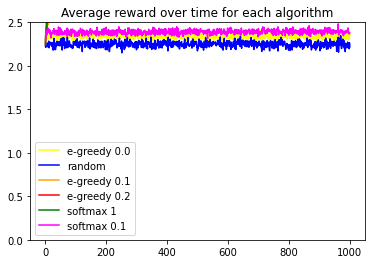

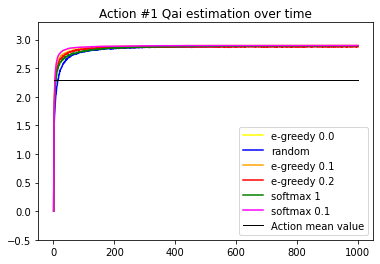

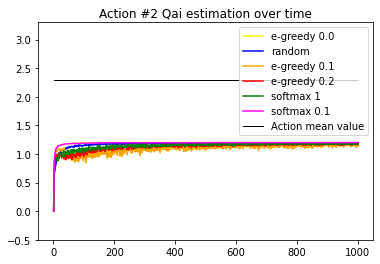

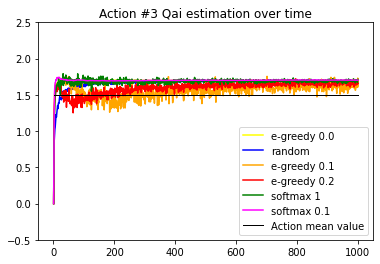

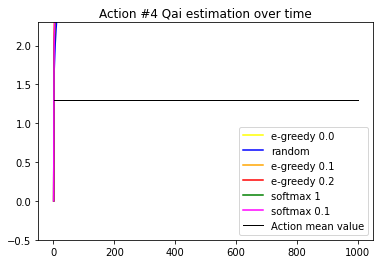

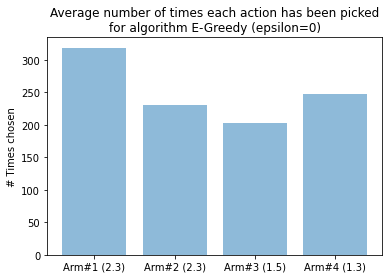

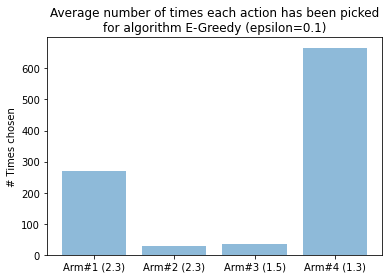

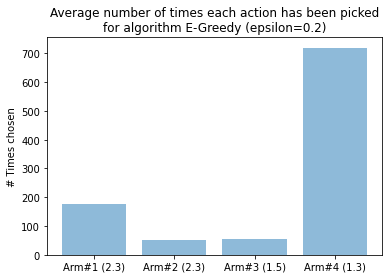

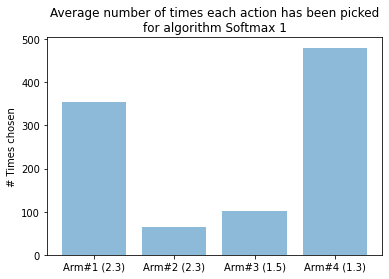

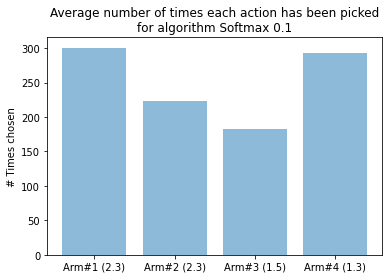

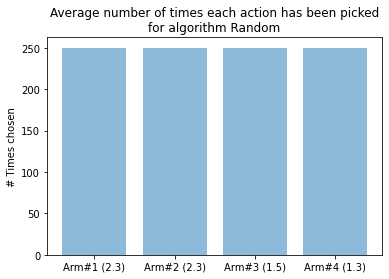

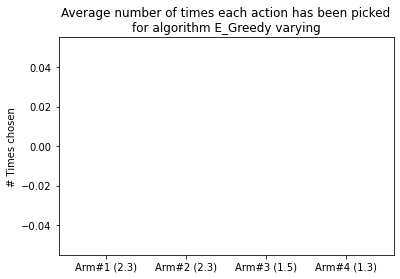

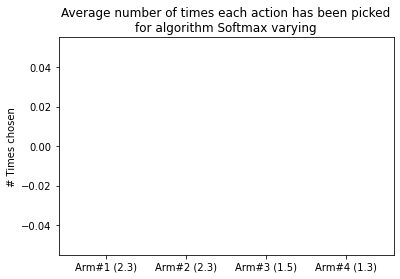

Process finished!


In [61]:
print('Creating slot machines... Question 1')

armed_bandits = []  # slot machines, these won't change after being initialized
# initializing the slot machines
for a in range(0, NB_ACTIONS):
    armed_bandits.append(ArmedBandit(Q_STAR_SIGMA[a][0], Q_STAR_SIGMA[a][1]))

strategy_runner = mainStrategy(NB_TIME_STEPS, NB_ITERATIONS, NB_ACTIONS, armed_bandits)

# first plot
avg_reward = np.zeros((8, NB_TIME_STEPS))  # 8x1000 array

# second batch of plots
arm_estimation = np.zeros((NB_ACTIONS, 8, NB_TIME_STEPS))  # 4x6x1000 array (4 arms, 8 algorithms)

# third batch of plots: number of times each arm is selected for each algorithm
arm_selection_counter = np.zeros((8, NB_ACTIONS))

print("Starting random")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, RANDOM_algo, True)

print("Starting greedy 0")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, EGREEDY_0_algo)

print("Starting greedy 0.1")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, EGREEDY_01_algo)

print("Starting greedy 0.2")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, EGREEDY_02_algo)

print("Starting Softmax 1")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, SOFTMAX_1_algo, False, 1)

print("Starting Softmax 0.1")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, SOFTMAX_01_algo, False, 0.1)

print("Plotting results")
plot_avg_reward(avg_reward, exercise3)
plot_arm_estimation(arm_estimation, exercise3)
plot_arm_selection_frequency(arm_selection_counter, exercise3)

plt.show()

print("Process finished!")

Creating slot machines... Question 2
Starting random
Starting greedy 0
Starting greedy 0.1
Starting greedy 0.2
Starting Softmax 1
Starting Softmax 0.1
Plotting results


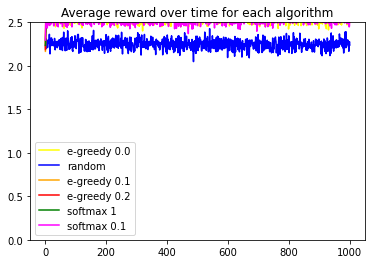

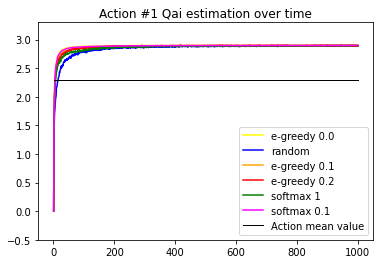

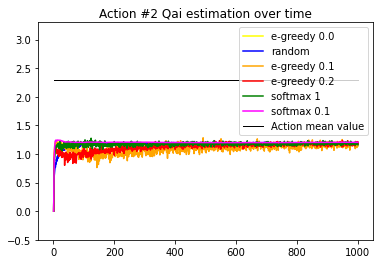

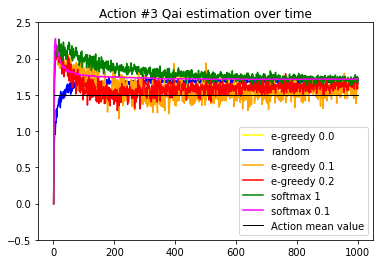

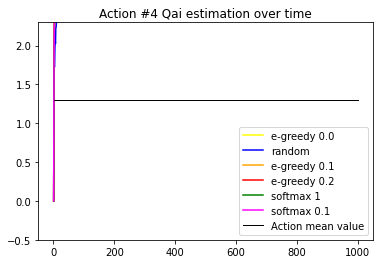

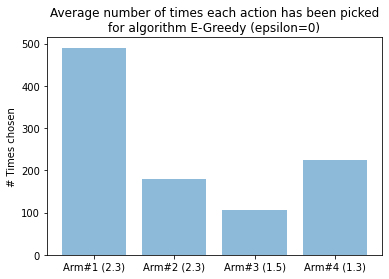

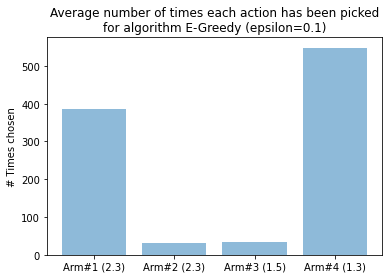

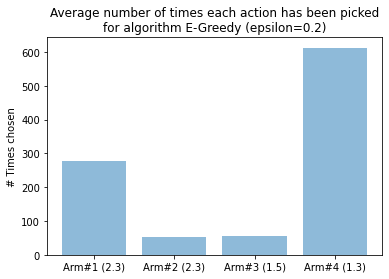

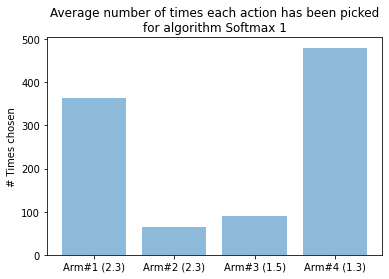

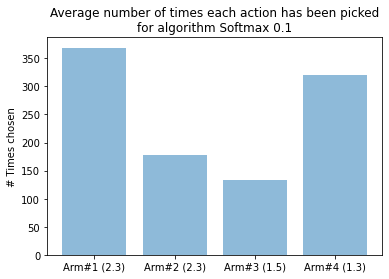

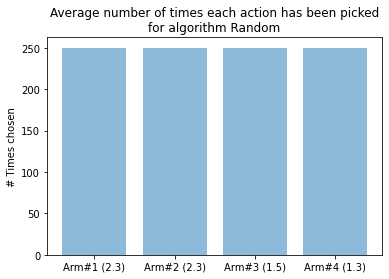

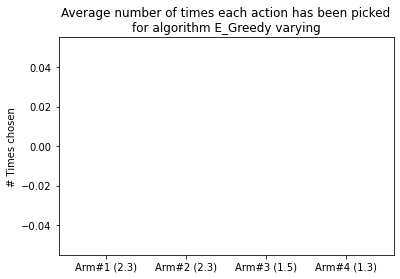

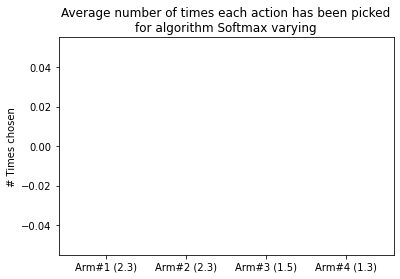

Process finished!


In [62]:
Q_STAR_SIGMA_DOUBLE = [(2.9, 1.4), (1.2, 1.6), (1.7, 4.0), (3.2, 2.4)]  # doubled noise

print('Creating slot machines... Question 2')

armed_bandits = []  # slot machines, these won't change after being initialized
# initializing the slot machines
for a in range(0, NB_ACTIONS):
    armed_bandits.append(ArmedBandit(Q_STAR_SIGMA_DOUBLE[a][0], Q_STAR_SIGMA_DOUBLE[a][1]))

strategy_runner = mainStrategy(NB_TIME_STEPS, NB_ITERATIONS, NB_ACTIONS, armed_bandits)

# first plot
avg_reward = np.zeros((8, NB_TIME_STEPS))  # 8x1000 array

# second batch of plots
arm_estimation = np.zeros((NB_ACTIONS, 8, NB_TIME_STEPS))  # 4x6x1000 array (4 arms, 8 algorithms)

# third batch of plots: number of times each arm is selected for each algorithm
arm_selection_counter = np.zeros((8, NB_ACTIONS))

print("Starting random")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, RANDOM_algo, True)

print("Starting greedy 0")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, EGREEDY_0_algo)

print("Starting greedy 0.1")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, EGREEDY_01_algo)

print("Starting greedy 0.2")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, EGREEDY_02_algo)

print("Starting Softmax 1")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, SOFTMAX_1_algo, False, 1)

print("Starting Softmax 0.1")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, SOFTMAX_01_algo, False, 0.1)

print("Plotting results")
plot_avg_reward(avg_reward, exercise3)
plot_arm_estimation(arm_estimation, exercise3)
plot_arm_selection_frequency(arm_selection_counter, exercise3)

plt.show()

print("Process finished!")

Creating slot machines... Question 3
Starting greedy varying
Starting softmax varying
Plotting results


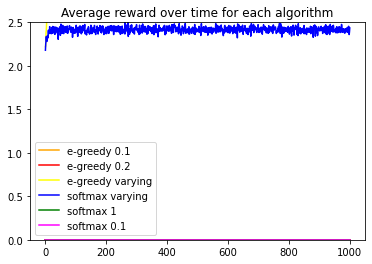

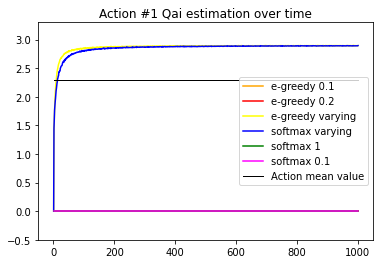

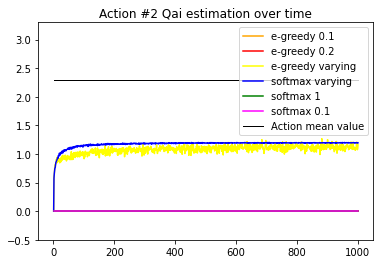

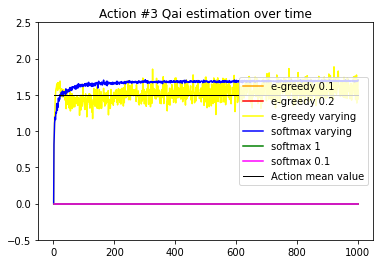

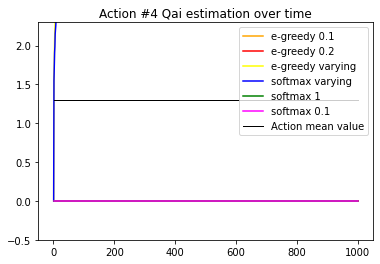

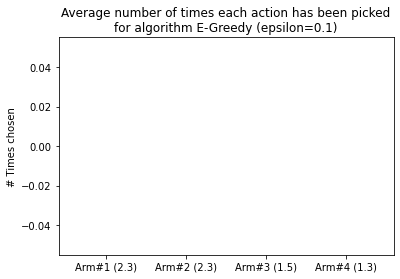

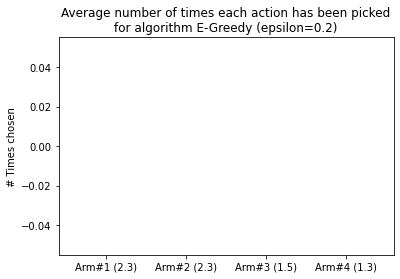

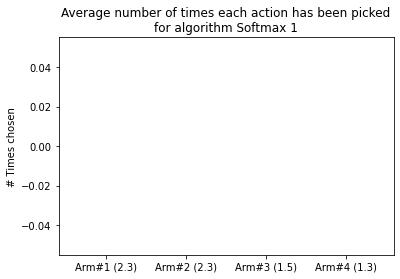

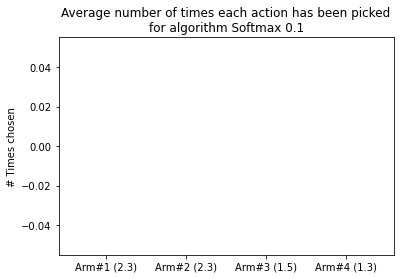

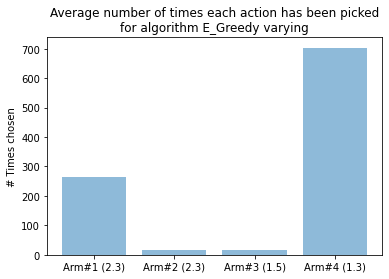

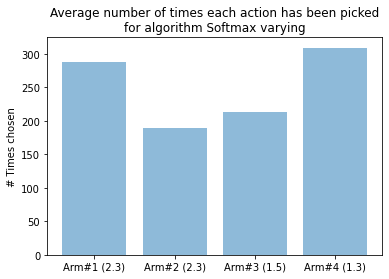

Process finished!


In [54]:
exercise3 = True
print('Creating slot machines... Question 3')

armed_bandits = []  # slot machines, these won't change after being initialized
# initializing the slot machines
for a in range(0, NB_ACTIONS):
    armed_bandits.append(ArmedBandit(Q_STAR_SIGMA[a][0], Q_STAR_SIGMA[a][1]))

strategy_runner = mainStrategy(NB_TIME_STEPS, NB_ITERATIONS, NB_ACTIONS, armed_bandits)
strategy_runner_ex3 = mainStrategy(NB_TIME_STEPS, NB_ITERATIONS, NB_ACTIONS, armed_bandits, exercise3)


# first plot
avg_reward = np.zeros((8, NB_TIME_STEPS))  # 8x1000 array

# second batch of plots
arm_estimation = np.zeros((NB_ACTIONS, 8, NB_TIME_STEPS))  # 4x6x1000 array (4 arms, 8 algorithms)

# third batch of plots: number of times each arm is selected for each algorithm
arm_selection_counter = np.zeros((8, NB_ACTIONS))

print("Starting random")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, RANDOM_algo, True)

print("Starting greedy 0")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, EGREEDY_0_algo)

print("Starting greedy 0.1")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, EGREEDY_01_algo)

print("Starting greedy 0.2")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, EGREEDY_02_algo)

print("Starting Softmax 1")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, SOFTMAX_1_algo, False, 1)

print("Starting Softmax 0.1")
strategy_runner.run_strategy(avg_reward, arm_estimation, arm_selection_counter, SOFTMAX_01_algo, False, 0.1)

print("Starting greedy varying")
strategy_runner_ex3.run_strategy(avg_reward, arm_estimation, arm_selection_counter, EGREEDY_VAR_algo)

print("Starting softmax varying")
strategy_runner_ex3.run_strategy(avg_reward, arm_estimation, arm_selection_counter, SOFTMAX_VAR_algo, False, 1)

print("Plotting results")
plot_avg_reward(avg_reward, exercise3)
plot_arm_estimation(arm_estimation, exercise3)
plot_arm_selection_frequency(arm_selection_counter, exercise3)

plt.show()

print("Process finished!")